In [1]:
from matplotlib import pyplot as plt
from torch import nn
import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms 
from torchvision import datasets
from PIL import Image 
import os
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
train_videos_path = r'C:\Users\mihai\Desktop\forehand-analysis\images_dataset\train'
test_videos_path = r'C:\Users\mihai\Desktop\forehand-analysis\images_dataset\test'

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((391, 422)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=train_videos_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

test_dataset = datasets.ImageFolder(root=test_videos_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [4]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 14
    Root location: C:\Users\mihai\Desktop\forehand-analysis\images_dataset\train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(391, 422), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

torch.Size([1, 391, 422])


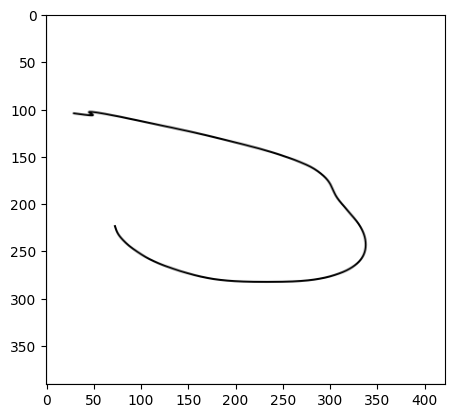

In [5]:
img, label = train_dataset[0]
img_height = img.shape[1]
img_width = img.shape[2]
print(img.shape)
plt.imshow(img.numpy().reshape(img_height, img_width), cmap='gray')

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(1, 16, 3) 
        self.layer2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten(start_dim=1)
        self.layer3 = nn.Linear(319488, 128)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.layer1(x))
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = F.relu(self.layer2(x))
        #print(x.shape)
        x = self.pool(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = F.relu(self.layer3(x))
        return self.fc(x)

In [7]:
model = ConvNet()

In [8]:
model(img.reshape(1,1,img_height,img_width)) # dodajemo batch_size=1

tensor([[0.0888]], grad_fn=<AddmmBackward0>)

In [9]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters())
device = 'gpu' if torch.cuda.is_available() else 'cpu'
model.to(device)

ConvNet(
  (layer1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer3): Linear(in_features=319488, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    model.train() 
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y = y.view(-1, 1).float()
        #print('y: ', y, ' : ', y.shape)
        preds = model(X)
        loss = loss_fn(preds, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [11]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval() 
    with torch.no_grad():
        total_loss = 0
        num_same = 0
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y = y.view(-1, 1).float()
            outputs = model(X)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

            print(outputs)

            if len(outputs.shape) == 2: # accuracy - dve klase
                preds = outputs > 0 # (izlazi > 0 -> klasa 1, izlazi <= 0 -> klasa 0)
                print(preds)
                num_same += sum(preds == y).item()
            else: # accuracy - vise klasa
                _, indices = torch.max(outputs, 1) # maks po dimenziji 1 jer je outputs.shape = (batch_size, num_classes)
                num_same += sum(indices == y).item()
        print(f'Average loss: {total_loss / len(dataloader.dataset)}')
        print(f'Accuracy: {num_same / len(dataloader.dataset)}')

In [12]:
num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    train_loop(train_loader, model, loss_fn, optimizer, device)
    test_loop(test_loader, model, loss_fn, device)

 10%|████████▎                                                                          | 1/10 [00:02<00:26,  3.00s/it]

tensor([[1.5111]])
tensor([[True]])
tensor([[1.5020]])
tensor([[True]])
tensor([[1.4899]])
tensor([[True]])
tensor([[1.4957]])
tensor([[True]])
tensor([[1.4893]])
tensor([[True]])
tensor([[1.5096]])
tensor([[True]])
Average loss: 0.9531569431225458
Accuracy: 0.5


 20%|████████████████▌                                                                  | 2/10 [00:06<00:25,  3.24s/it]

tensor([[0.7229]])
tensor([[True]])
tensor([[0.7788]])
tensor([[True]])
tensor([[0.7745]])
tensor([[True]])
tensor([[0.7559]])
tensor([[True]])
tensor([[0.6929]])
tensor([[True]])
tensor([[0.6524]])
tensor([[True]])
Average loss: 0.7613197962443033
Accuracy: 0.5


 30%|████████████████████████▉                                                          | 3/10 [00:10<00:25,  3.64s/it]

tensor([[0.8369]])
tensor([[True]])
tensor([[1.0827]])
tensor([[True]])
tensor([[0.9879]])
tensor([[True]])
tensor([[0.5626]])
tensor([[True]])
tensor([[0.3820]])
tensor([[True]])
tensor([[1.0469]])
tensor([[True]])
Average loss: 0.7919385880231857
Accuracy: 0.5


 40%|█████████████████████████████████▏                                                 | 4/10 [00:14<00:23,  3.83s/it]

tensor([[1.6031]])
tensor([[True]])
tensor([[1.7498]])
tensor([[True]])
tensor([[1.2246]])
tensor([[True]])
tensor([[0.3316]])
tensor([[True]])
tensor([[1.8539]])
tensor([[True]])
tensor([[-0.1893]])
tensor([[False]])
Average loss: 0.9157487874229749
Accuracy: 0.6666666666666666


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:18<00:19,  3.92s/it]

tensor([[1.2306]])
tensor([[True]])
tensor([[0.7912]])
tensor([[True]])
tensor([[-2.8395]])
tensor([[False]])
tensor([[-0.4917]])
tensor([[False]])
tensor([[0.6375]])
tensor([[True]])
tensor([[-2.4615]])
tensor([[False]])
Average loss: 1.107565265148878
Accuracy: 0.3333333333333333


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:22<00:15,  3.98s/it]

tensor([[2.8960]])
tensor([[True]])
tensor([[-3.6987]])
tensor([[False]])
tensor([[-2.7588]])
tensor([[False]])
tensor([[3.8752]])
tensor([[True]])
tensor([[3.4452]])
tensor([[True]])
tensor([[1.3589]])
tensor([[True]])
Average loss: 1.749920935370028
Accuracy: 0.5


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:26<00:12,  4.03s/it]

tensor([[6.3428]])
tensor([[True]])
tensor([[-2.2326]])
tensor([[False]])
tensor([[-3.1147]])
tensor([[False]])
tensor([[4.9609]])
tensor([[True]])
tensor([[5.5210]])
tensor([[True]])
tensor([[3.0014]])
tensor([[True]])
Average loss: 2.3838295033201575
Accuracy: 0.5


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:31<00:08,  4.06s/it]

tensor([[4.8361]])
tensor([[True]])
tensor([[3.6135]])
tensor([[True]])
tensor([[1.0263]])
tensor([[True]])
tensor([[3.2478]])
tensor([[True]])
tensor([[-4.6789]])
tensor([[False]])
tensor([[-5.5467]])
tensor([[False]])
Average loss: 2.253426222402292
Accuracy: 0.5


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:35<00:04,  4.08s/it]

tensor([[0.3419]])
tensor([[True]])
tensor([[2.6367]])
tensor([[True]])
tensor([[4.3292]])
tensor([[True]])
tensor([[-6.5397]])
tensor([[False]])
tensor([[2.9534]])
tensor([[True]])
tensor([[-5.6598]])
tensor([[False]])
Average loss: 2.2695255465999558
Accuracy: 0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.94s/it]

tensor([[3.0049]])
tensor([[True]])
tensor([[3.3175]])
tensor([[True]])
tensor([[0.6699]])
tensor([[True]])
tensor([[-5.5723]])
tensor([[False]])
tensor([[-6.4784]])
tensor([[False]])
tensor([[4.7882]])
tensor([[True]])
Average loss: 2.364808045056028
Accuracy: 0.5
